In [1]:
import pandas as pd
from math import *
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [2]:
# parent_dir = 'SIMSbinarybTY0'
parent_dir = 'SIMSbTY0_ordered'

data_lst = []
for f in os.listdir(parent_dir):
    if "SIMS" in f:
        seed = f.split(".")[0].split('-')[-1]
        nsim = f.split('.')[0].split('-')[-2]
        if "c." in f:
            data = pd.read_csv(os.path.join(parent_dir, f))
            data['seed'] = seed
            data['crossfit'] = True
            data['nsim'] = nsim
            data_lst.append(data)

        else:
            data = pd.read_csv(os.path.join(parent_dir, f))
            data['seed'] = seed
            data['crossfit'] = False
            data['nsim'] = nsim
            data_lst.append(data)



SIMS = pd.concat(data_lst)
df = SIMS.copy()
df = df.loc[:, ~df.isna().all()]
df = df.dropna(axis = 0)

print(df.shape)
df.head()


(20000, 20)


,ATEBoot00,ATENaive,RegressionTrue,P2SLS,ATEBoot10,ATEBoot11,ATEBoot12,PartialCorrTYU,confounding,ATEBoot00pval,ATENaivepval,ATEBoot10pval,ATEBoot11pval,ATEBoot12pval,ATE2pval,ground_truthpval,bTY,seed,crossfit,nsim
0,-1.518911,-1.622363,-0.302720,-1.436121,-1.485326,-1.194604,-1.504369,-0.481296,0,2.392713e-08,3.013738e-09,3.626233e-08,0.000033,4.326058e-08,9.679142e-08,0.342778,0,1,False,1000
1,0.268152,0.372684,-0.352091,-0.801856,0.209610,-0.406372,-0.543796,0.130413,1,2.416427e-01,1.030658e-01,3.715511e-01,0.104398,3.806228e-02,1.822265e-03,0.164028,0,1,False,1000
2,0.215662,0.014937,0.354733,0.160039,0.217494,0.773774,0.781051,0.060365,0,2.155203e-01,9.310519e-01,2.130292e-01,0.000035,3.163824e-05,3.731914e-01,0.065341,0,1,False,1000
3,-0.914588,-1.197806,-0.186981,-1.465246,-0.921453,-0.102534,-0.078106,-0.115714,0,9.718254e-06,5.553665e-09,8.318598e-06,0.640476,7.228434e-01,1.211585e-05,0.541083,0,1,False,1000
4,-0.299383,-0.159956,-0.272053,-0.154478,-0.298944,-0.533403,-0.529983,-0.034781,0,1.746136e-01,4.590539e-01,1.750284e-01,0.017014,1.762597e-02,5.980513e-01,0.262191,0,1,False,1000


In [3]:
alphas = np.arange(0, 1, 0.01)

reject_naive = [(df['ATENaivepval'] < alpha).mean() for alpha in alphas]
reject_boot = [(df['ATEBoot00pval'] < alpha).mean() for alpha in alphas]
reject_boot12 = [(df['ATEBoot12pval'] < alpha).mean() for alpha in alphas]
reject_oracle = [(df['ground_truthpval'] < alpha).mean() for alpha in alphas]

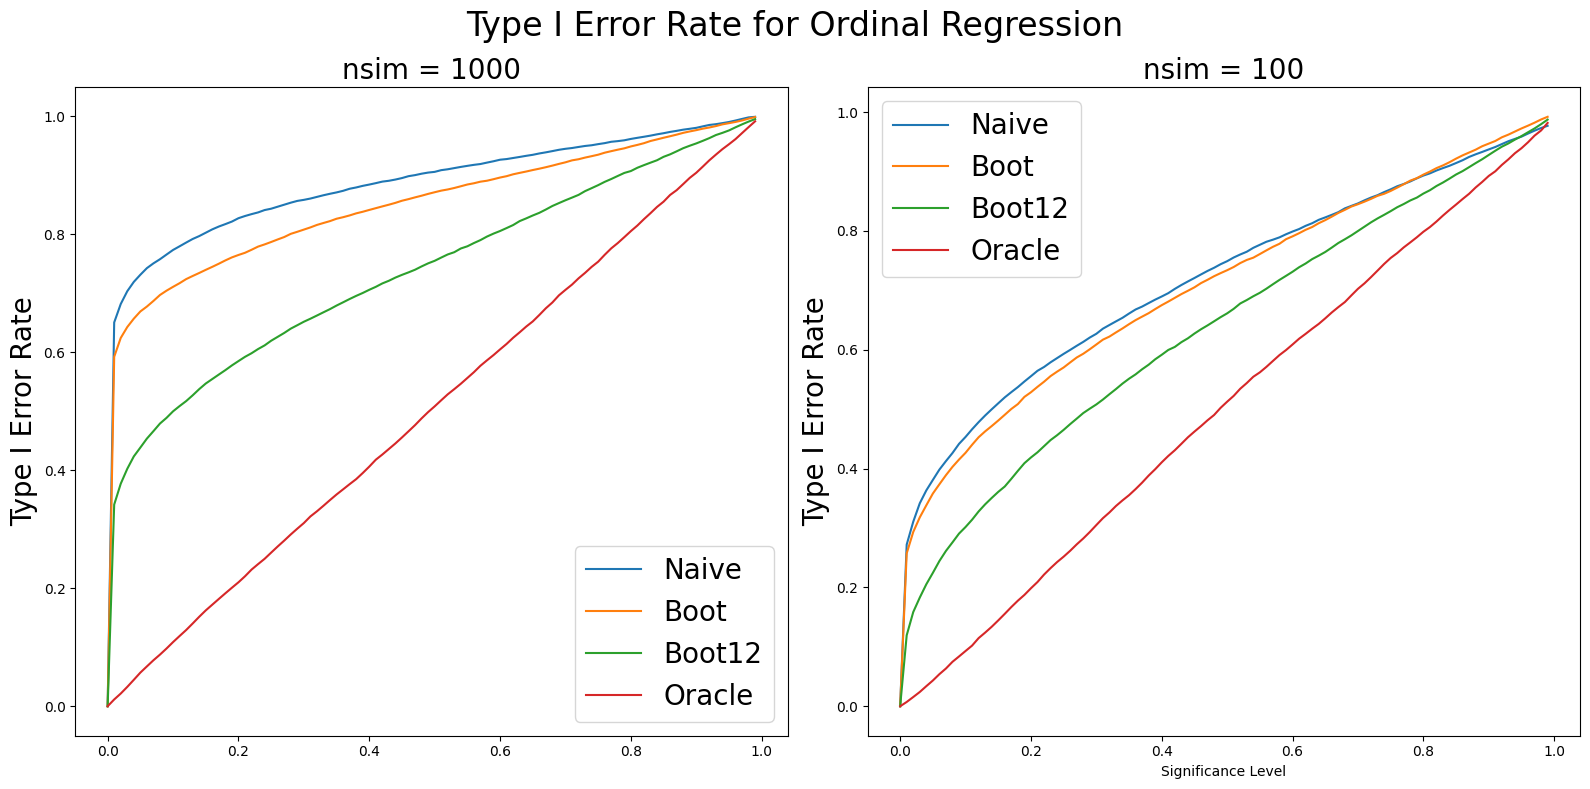

In [4]:
fig, axes = plt.subplots(1,len(df['nsim'].unique()), figsize=(16, 8), sharex=True)
if len(df['nsim'].unique()) == 1:
    axes = [axes]

for idx, nsim in enumerate(df['nsim'].unique()):
    df_nsim = df[df['nsim'] == nsim]
    reject_naive_nsim = [(df_nsim['ATENaivepval'] < alpha).mean() for alpha in alphas]
    reject_boot00_nsim = [(df_nsim['ATEBoot00pval'] < alpha).mean() for alpha in alphas]
    reject_boot12_nsim = [(df_nsim['ATEBoot12pval'] < alpha).mean() for alpha in alphas]
    reject_oracle_nsim = [(df_nsim['ground_truthpval'] < alpha).mean() for alpha in alphas]
    
    axes[idx].plot(alphas, reject_naive_nsim, label='Naive')
    axes[idx].plot(alphas, reject_boot00_nsim, label='Boot')
    axes[idx].plot(alphas, reject_boot12_nsim, label='Boot12')
    axes[idx].plot(alphas, reject_oracle_nsim, label='Oracle')

    axes[idx].set_title(f'nsim = {nsim}', fontsize=20)
    axes[idx].set_ylabel('Type I Error Rate', fontsize=20)
    axes[idx].legend(fontsize=20)

plt.xlabel('Significance Level')
fig.suptitle('Type I Error Rate for Ordinal Regression', fontsize=24)
plt.tight_layout()
plt.savefig('figs/type1error_naive_boot.png')


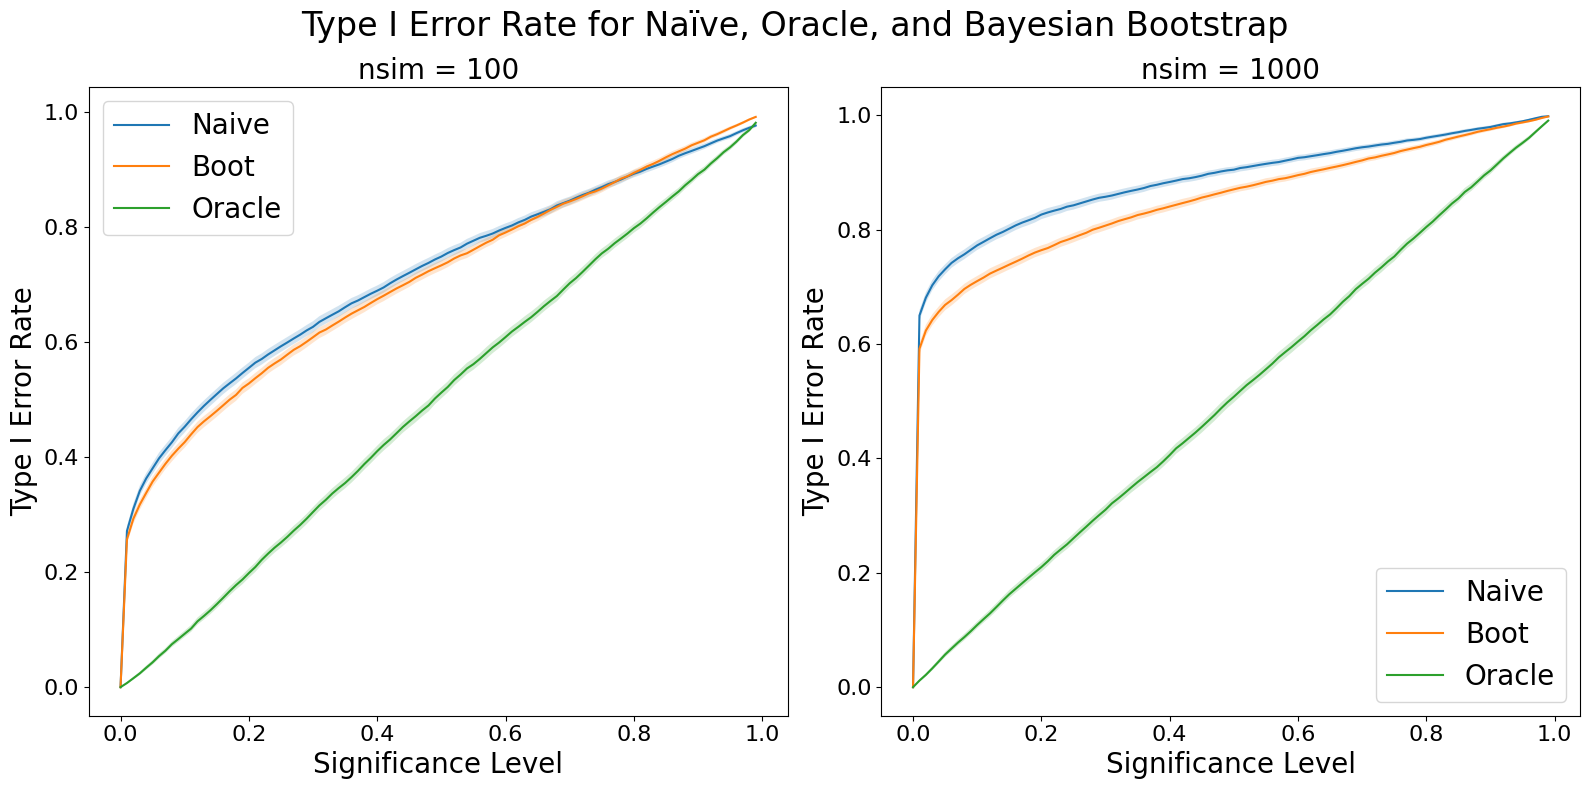

In [5]:
fig, axes = plt.subplots(1,len(df['nsim'].unique()), figsize=(16, 8), sharex=True)
if len(df['nsim'].unique()) == 1:
    axes = [axes]

# Number of bootstrap samples
n_bootstrap = 1000

for idx, nsim in enumerate(["100","1000"]):
    df_nsim = df[df['nsim'] == nsim]
    
    # Initialize arrays to store bootstrap results
    reject_naive_boot = np.zeros((n_bootstrap, len(alphas)))
    reject_boot00_boot = np.zeros((n_bootstrap, len(alphas)))
    reject_boot12_boot = np.zeros((n_bootstrap, len(alphas)))
    reject_oracle_boot = np.zeros((n_bootstrap, len(alphas)))
    
    # Perform bootstrap
    for b in range(n_bootstrap):
        boot_idx = np.random.choice(len(df_nsim), size=len(df_nsim), replace=True)
        df_boot = df_nsim.iloc[boot_idx]
        
        reject_naive_boot[b] = [(df_boot['ATENaivepval'] < alpha).mean() for alpha in alphas]
        reject_boot00_boot[b] = [(df_boot['ATEBoot00pval'] < alpha).mean() for alpha in alphas]
        reject_oracle_boot[b] = [(df_boot['ground_truthpval'] < alpha).mean() for alpha in alphas]
    
    # Calculate means and confidence intervals
    reject_naive_mean = reject_naive_boot.mean(axis=0)
    reject_boot00_mean = reject_boot00_boot.mean(axis=0)
    reject_boot12_mean = reject_boot12_boot.mean(axis=0)
    reject_oracle_mean = reject_oracle_boot.mean(axis=0)
    
    reject_naive_ci = np.percentile(reject_naive_boot, [2.5, 97.5], axis=0)
    reject_boot00_ci = np.percentile(reject_boot00_boot, [2.5, 97.5], axis=0)
    reject_boot12_ci = np.percentile(reject_boot12_boot, [2.5, 97.5], axis=0)
    reject_oracle_ci = np.percentile(reject_oracle_boot, [2.5, 97.5], axis=0)
    
    # Plot means and confidence intervals
    axes[idx].plot(alphas, reject_naive_mean, label='Naive')
    axes[idx].fill_between(alphas, reject_naive_ci[0], reject_naive_ci[1], alpha=0.2)
    
    axes[idx].plot(alphas, reject_boot00_mean, label='Boot')
    axes[idx].fill_between(alphas, reject_boot00_ci[0], reject_boot00_ci[1], alpha=0.2)
    
    axes[idx].plot(alphas, reject_oracle_mean, label='Oracle')
    axes[idx].fill_between(alphas, reject_oracle_ci[0], reject_oracle_ci[1], alpha=0.2)

    axes[idx].set_title(f'nsim = {nsim}', fontsize=20)
    axes[idx].set_ylabel('Type I Error Rate', fontsize=20)
    axes[idx].set_xlabel('Significance Level', fontsize = 20)
    axes[idx].legend(fontsize=20)
    axes[idx].tick_params(axis='both', labelsize=16)

fig.suptitle('Type I Error Rate for Naïve, Oracle, and Bayesian Bootstrap', fontsize=24)
plt.tight_layout()
plt.savefig('figs/type1error_naive_boot_binary.png')


In [6]:
# alphas = np.arange(0, 1, 0.01)

# reject_naive = [(df['ATEBoot12pval'] < alpha).mean() for alpha in alphas]
# reject_boot = [(df['ATEBoot11pval'] < alpha).mean() for alpha in alphas]

# plt.plot(alphas, reject_naive, label = 'Naive')
# plt.plot(alphas, reject_boot, label = 'Boot')
# plt.plot(alphas, alphas, label = 'Nominal', linestyle='-')
# plt.title('Type I Error Rate for Ordinal Regression')
# plt.xlabel('Significance Level')
# plt.ylabel('Type I Error Rate')
# plt.suptitle(f'n = {len(alphas)}')
# plt.legend()
# plt.show()
